In [ ]:
import torch
import torchvision
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/My Drive/Histopathology data/segmented images.zip" "segmented images.zip"

In [ ]:
!unzip -q "segmented images.zip"

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
with open('files_list.txt', 'r') as fp:
    files = fp.read().splitlines()
classes_str = [file.split('/')[0] for file in files]
classes_str, classes = np.unique(classes_str, return_inverse=True)
print(classes_str)

train_files, test_files, train_classes, test_classes = train_test_split(files, classes, train_size=0.7, test_size=0.3, stratify=classes)


['NORM' 'TUM']


In [ ]:
from PIL import Image
import torch.utils.data as data
class Hist(data.Dataset):
    def __init__(self, root, files, classes, transforms=None):
        self.root = root
        self.files = files
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, item):
        image = Image.open(os.path.join(self.root, self.files[item])).convert(mode="RGB")
        class_ = self.classes[item]
        if self.transforms:
            image = self.transforms(image)
        return image, class_

    def __len__(self):
        return len(self.files)

In [ ]:
batch_size_train = 10 # 
batch_size_test = 10#

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.Resize((224, 224)),
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#image datasets
train_dataset = Hist('segmented images/', train_files, train_classes, 
                         transforms=image_transform)
test_dataset = Hist('segmented images/', test_files, test_classes, 
                        transforms=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True, num_workers=2)

Label: NORM


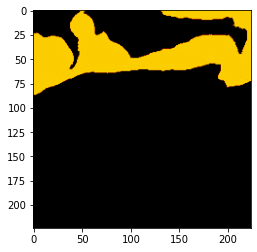

In [ ]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0]
# show the data
plt.imshow(sample.permute(1, 2, 0));
print("Label: " + str(classes_str[labels[0]]))

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

class Inceptionblock(nn.Module):
    def __init__(self, input_channels, n1x1, n3x3_reduce, n3x3, n5x5_reduce, n5x5, pool):
        super().__init__()

        # convolution: 1x1 
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channels, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace=True)
        )

        # convolution: 1x1  -> convolution: 3x3 
        self.b2 = nn.Sequential(
            nn.Conv2d(input_channels, n3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(n3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n3x3_reduce, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace=True)
        )

        # convolution: 1x1 -> convolution: 5x5
        # Two 3x3 stacked convolution filters used
        self.b3 = nn.Sequential(
            nn.Conv2d(input_channels, n5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(n5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5_reduce, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5, n5x5),
            nn.ReLU(inplace=True),
            nn.Conv2d(n5x5, n5x5, kernel_size=3, padding=1),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace=True)
        )

        # pooling: 3x3 -> convolution: 1x1
        
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(input_channels, pool, kernel_size=1),
            nn.BatchNorm2d(pool),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return torch.cat([self.b1(x), self.b2(x), self.b3(x), self.b4(x)], dim=1)


class GoogleNet(nn.Module):

    def __init__(self, num_class=2):
        super().__init__()
        self.prelayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )

        
        self.a3 = Inceptionblock(192, 64, 96, 128, 16, 32, 32)
        self.b3 = Inceptionblock(256, 128, 128, 192, 32, 96, 64)

        # The Inception network consists of inception modules stacked upon each other, with occasional max-pooling layers
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inceptionblock(480, 192, 96, 208, 16, 48, 64)
        self.b4 = Inceptionblock(512, 160, 112, 224, 24, 64, 64)
        self.c4 = Inceptionblock(512, 128, 128, 256, 24, 64, 64)
        self.d4 = Inceptionblock(512, 112, 144, 288, 32, 64, 64)
        self.e4 = Inceptionblock(528, 256, 160, 320, 32, 128, 128)

        self.a5 = Inceptionblock(832, 256, 160, 320, 32, 128, 128)
        self.b5 = Inceptionblock(832, 384, 192, 384, 48, 128, 128)

        #input feature size: 8*8*1024
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout2d(p=0.4)
        self.linear = nn.Linear(1024, num_class)

    def forward(self, x):
        x = self.prelayer(x)
        x = self.maxpool(x)
        x = self.a3(x)
        x = self.b3(x)

        x = self.maxpool(x)

        x = self.a4(x)
        x = self.b4(x)
        x = self.c4(x)
        x = self.d4(x)
        x = self.e4(x)

        x = self.maxpool(x)

        x = self.a5(x)
        x = self.b5(x)

        
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size()[0], -1)
        x = self.linear(x)

        return x

In [ ]:
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GoogleNet().to(device)
learning_rate = 0.0004
weight_decay = 0.001
for param in model.parameters():
    param.requires_grad = True
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.SGD(parameters, lr=learning_rate, momentum=0.9)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer):
    # meter
    loss = AverageMeter()
    # switch to train mode
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for batch_idx, (data, target) in enumerate(tk0):
        # after fetching the data transfer the model to the 
        # required device, in this example the device is gpu
        # transfer to gpu can also be done by 
        # data, target = data.cuda(), target.cuda()
        data, target = data.to(device), target.to(device)  
        # compute the forward pass
        # it can also be achieved by model.forward(data)
        output = model(data) 
        # compute the loss function
        loss_this = F.cross_entropy(output, target)
        # initialize the optimizer
        optimizer.zero_grad()
        # compute the backward pass
        loss_this.backward()
        # update the parameters
        optimizer.step()
        # update the loss meter 
        loss.update(loss_this.item(), target.shape[0])
    print('Train: Average loss: {:.4f}\n'.format(loss.avg))
    return loss.avg    
##define test function
def test(model, device, test_loader):
    # meters
    loss = AverageMeter()
    acc = AverageMeter()
    correct = 0
    # switch to test mode
    model.eval()
    for data, target in test_loader:
      
        data, target = data.to(device), target.to(device)  # data, target = data.cuda(), target.cuda()
        # since we dont need to backpropagate loss in testing,
        # we dont keep the gradient
        with torch.no_grad():
            # compute the forward pass
            # it can also be achieved by model.forward(data)
            output = model(data)
        # compute the loss function just for checking
        loss_this = F.cross_entropy(output, target) # sum up batch loss
        # get the index of the max log-probability
        pred = output.argmax(dim=1, keepdim=True) 
        # check which are correct
        correct_this = pred.eq(target.view_as(pred)).sum().item()
        # accumulate the correct ones
        correct += correct_this
        # compute accuracy
        acc_this = correct_this/target.shape[0]*100.0
        # update the loss and accuracy meter 
        acc.update(acc_this, target.shape[0])
        loss.update(loss_this.item(), target.shape[0])
    print('Test: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.avg, correct, len(test_loader.dataset), acc.avg))
    return loss.avg,acc.avg

In [ ]:
import os.path
from os import path

num_epoch = 30
train_loss=[]
test_loss=[]
accuracy_test=[]
acc=0
for epoch in range(1, num_epoch + 1):
    print(epoch)
    tl=train(model, device, train_loader, optimizer)
    stl,acct=test(model, device, test_loader)
    if acc<acct:
      if path.exists("GoogleNetsegmentsgd.pth"):
        os.remove("GoogleNetsegmentsgd.pth")

      torch.save(model.state_dict(), 'GoogleNetsegmentsgd.pth')
      acc=acct
print(acc)

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.6094

Test: Average loss: 0.5441, Accuracy: 1528/2160 (70.74%)

2


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.5590

Test: Average loss: 0.5227, Accuracy: 1553/2160 (71.90%)

3


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.5319

Test: Average loss: 0.4752, Accuracy: 1676/2160 (77.59%)

4


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.5100

Test: Average loss: 0.4603, Accuracy: 1686/2160 (78.06%)

5


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.5022

Test: Average loss: 0.4556, Accuracy: 1693/2160 (78.38%)

6


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.4853

Test: Average loss: 0.4799, Accuracy: 1645/2160 (76.16%)

7


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.4668

Test: Average loss: 0.5991, Accuracy: 1617/2160 (74.86%)

8


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.4674

Test: Average loss: 0.6054, Accuracy: 1523/2160 (70.51%)

9


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.4431

Test: Average loss: 0.6974, Accuracy: 1554/2160 (71.94%)

10


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.4399

Test: Average loss: 0.5187, Accuracy: 1608/2160 (74.44%)

11


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.4214

Test: Average loss: 0.7862, Accuracy: 1365/2160 (63.19%)

12


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.4090

Test: Average loss: 0.6074, Accuracy: 1509/2160 (69.86%)

13


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.3820

Test: Average loss: 1.2232, Accuracy: 1246/2160 (57.69%)

14


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.3874

Test: Average loss: 0.5134, Accuracy: 1698/2160 (78.61%)

15


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.3620

Test: Average loss: 0.6789, Accuracy: 1501/2160 (69.49%)

16


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.3582

Test: Average loss: 0.4947, Accuracy: 1671/2160 (77.36%)

17


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.3475

Test: Average loss: 1.3377, Accuracy: 1273/2160 (58.94%)

18


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.3125

Test: Average loss: 0.9015, Accuracy: 1600/2160 (74.07%)

19


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.2862

Test: Average loss: 0.8420, Accuracy: 1603/2160 (74.21%)

20


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.2927

Test: Average loss: 0.7845, Accuracy: 1544/2160 (71.48%)

21


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.2823

Test: Average loss: 1.1998, Accuracy: 1303/2160 (60.32%)

22


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.2488

Test: Average loss: 0.6780, Accuracy: 1667/2160 (77.18%)

23


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.2468

Test: Average loss: 2.1671, Accuracy: 1138/2160 (52.69%)

24


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.2243

Test: Average loss: 2.8914, Accuracy: 1127/2160 (52.18%)

25


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.2082

Test: Average loss: 0.6376, Accuracy: 1662/2160 (76.94%)

26


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.1889

Test: Average loss: 0.7387, Accuracy: 1642/2160 (76.02%)

27


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.1751

Test: Average loss: 0.8599, Accuracy: 1677/2160 (77.64%)

28


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.1806

Test: Average loss: 1.1125, Accuracy: 1612/2160 (74.63%)

29


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.1625

Test: Average loss: 1.1833, Accuracy: 1420/2160 (65.74%)

30


  0%|          | 0/504 [00:00<?, ?it/s]

Train: Average loss: 0.1661

Test: Average loss: 1.1675, Accuracy: 1458/2160 (67.50%)

78.61111111111111


In [ ]:
!cp GoogleNetsegmentmodel.pth '/content/drive/My Drive/Histopathology data/'